這份 Notebook 示範 OpenAI Embedding API、語意搜尋、K-means 分群，最後透過 LLM 幫每一群訂出主題

In [1]:
from google.colab import userdata
openai_api_key = userdata.get('openai_api_key')

In [2]:
import requests
import json
from pprint import pp

In [3]:
def get_completion(messages, model="gpt-3.5-turbo", temperature=0, max_tokens=300):
  payload = { "model": model, "temperature": temperature, "messages": messages, "max_tokens": max_tokens }
  headers = { "Authorization": f'Bearer {openai_api_key}', "Content-Type": "application/json" }
  response = requests.post('https://api.openai.com/v1/chat/completions', headers = headers, data = json.dumps(payload) )
  obj = json.loads(response.text)
  if response.status_code == 200 :
    return obj["choices"][0]["message"]["content"]
  else :
    return obj["error"]

## Embeddings API

官方指南
* https://platform.openai.com/docs/guides/embeddings/what-are-embeddings
* https://platform.openai.com/docs/guides/embeddings/use-cases 推薦看一下 Use Cases

## 定義一個輔助函數可以拿到 vector

In [ ]:
def get_embeddings(input, dimensions = 1536, model="text-embedding-3-small"):
  payload = { "input": input, "model": model, "dimensions": dimensions }
  headers = { "Authorization": f'Bearer {openai_api_key}', "Content-Type": "application/json" }
  response = requests.post('https://api.openai.com/v1/embeddings', headers = headers, data = json.dumps(payload) )
  obj = json.loads(response.text)
  if response.status_code == 200 :
    return obj["data"][0]["embedding"]
  else :
    return obj["error"]

In [ ]:
x = get_embeddings("test")
print(x)

[-0.009877119, 0.0015331338, 0.015642809, -0.054763675, -0.006405938, -0.012950308, 0.009662549, -0.013552487, 0.028683098, 0.007862934, 0.03181166, -0.00654437, 0.0038587903, 0.010153983, 0.014057764, 0.044658143, -0.0598026, -0.002439863, -0.05110907, 0.036518347, 0.03610305, 0.024419393, 0.03995146, -0.04355069, 0.03455261, -0.019560434, -0.013981626, 0.01061773, 0.031202558, -0.041557267, 0.058805887, -0.028876903, -0.0013644198, -0.038733255, 0.05517897, 0.004139115, 0.02357496, 0.01885443, -0.0056687878, -0.003966075, -0.041446522, -0.045018066, 0.011351419, 0.027257249, 0.030012045, -0.018785214, -0.034386493, -0.038677882, 0.04850655, 0.02786635, -0.031783972, -0.0027790212, 0.048229687, 0.07021268, 0.019325098, 0.023921039, -0.035189398, 0.019920357, 0.01854988, 0.0053365515, -0.0022962398, -0.018840587, 0.03840102, 0.0055061304, -0.031977776, -0.060079463, 0.012237384, 0.031479422, 0.00043973772, 0.021526167, 0.04593172, 0.011884382, -0.012811876, 0.016750265, 0.0087281335, 0

In [ ]:
len(x)

1536

In [ ]:
x = get_embeddings("test", 8)
print(x)

[-0.1596108, 0.024774905, 0.25278234, -0.8849619, -0.103517726, -0.20927246, 0.15614343, -0.21900345]


In [ ]:
x = get_embeddings("test", 1)
print(x)

[-1.0]


In [ ]:
# 拿書籍資料為例
url = "https://ihower.tw/data/books-dataset.csv"
response = requests.get(url)

In [ ]:
import pandas as pd
from io import StringIO
df = pd.read_csv(StringIO(response.text))

In [ ]:
df

,title,description,category
0,1分鐘驚豔 ChatGPT 爆款文案寫作聖經：寫作教練 Vista 教你用 ChatGPT ...,你不會被AI取代，但有可能會被懂得用AI的人取代。\r\nVistaＸChatGPT雙強加持...,ChatGPT
1,駭客入侵免驚，不是高手也會的 WordPress 資安防禦大全,☛ 個人資料成為數位時代的新石油，在駭客環伺之下，\r\n\r\n你的網站是否做好準備了呢！...,Wordpress
2,ChatGPT~IG行銷最強魔法師~：AI智慧繪圖撰文、視覺行銷、攬客吸睛、拍照秘技、Has...,本書將帶你從零開始初試 IG 的異想世界，了解 Instagram 對社群團體的重要性。逐步...,ChatGPT
3,一生金錢無虞平衡理財法,養成有紀律的理財習慣\r\n活出不為金錢煩惱的充實人生\r\n\r\n為何成功的散戶有如鳳毛...,投資理財
4,Roblox 遊戲設計大全 -- 邊做邊玩邊學速成攻略！,★全國第一本ROBLOX遊戲設計基礎教學！日本初上市便榮登Amazon遊戲程式設計類第2名！...,遊戲設計
...,...,...,...
335,The Age of Emoji: Creating the Lexicon of Mobi...,Follow design trends and opportunities in the ...,行動通訊
336,Computer Vision on AWS: Build and deploy real-...,Scale up your Windows containers seamlessly on...,AWS
337,Pretrain Vision and Large Language Models in P...,Master the art of training vision and large la...,AWS
338,The Distributed Functions of Emergency Managem...,The Distributed Functions of Emergency Managem...,資訊安全


### 拿書名跟描述拿計算 embedding

In [ ]:
df['embeddings'] = None

for index, row in df.iterrows():
    df.at[index, 'embeddings'] = get_embeddings( f"{row['title']} {row['description']}" )

# 要跑一段時間，因為每一筆都呼叫 API 算出 embedding 向量

df

,title,description,category,embeddings
0,1分鐘驚豔 ChatGPT 爆款文案寫作聖經：寫作教練 Vista 教你用 ChatGPT ...,你不會被AI取代，但有可能會被懂得用AI的人取代。\r\nVistaＸChatGPT雙強加持...,ChatGPT,"[-0.003281127, 0.0060829883, 0.010891446, -0.0..."
1,駭客入侵免驚，不是高手也會的 WordPress 資安防禦大全,☛ 個人資料成為數位時代的新石油，在駭客環伺之下，\r\n\r\n你的網站是否做好準備了呢！...,Wordpress,"[0.0025324596, 0.030259408, 0.024553241, 0.033..."
2,ChatGPT~IG行銷最強魔法師~：AI智慧繪圖撰文、視覺行銷、攬客吸睛、拍照秘技、Has...,本書將帶你從零開始初試 IG 的異想世界，了解 Instagram 對社群團體的重要性。逐步...,ChatGPT,"[-0.02116455, 0.031369507, -0.02816522, 0.0055..."
3,一生金錢無虞平衡理財法,養成有紀律的理財習慣\r\n活出不為金錢煩惱的充實人生\r\n\r\n為何成功的散戶有如鳳毛...,投資理財,"[0.06258343, 0.008527952, 0.015160804, 0.07133..."
4,Roblox 遊戲設計大全 -- 邊做邊玩邊學速成攻略！,★全國第一本ROBLOX遊戲設計基礎教學！日本初上市便榮登Amazon遊戲程式設計類第2名！...,遊戲設計,"[-0.0064139166, 0.025042934, 0.005316929, 0.03..."
...,...,...,...,...
335,The Age of Emoji: Creating the Lexicon of Mobi...,Follow design trends and opportunities in the ...,行動通訊,"[0.061634105, 0.023565289, -0.0034172607, 0.01..."
336,Computer Vision on AWS: Build and deploy real-...,Scale up your Windows containers seamlessly on...,AWS,"[0.041941002, 0.008157038, 0.033181172, 0.0184..."
337,Pretrain Vision and Large Language Models in P...,Master the art of training vision and large la...,AWS,"[0.03739364, -0.011453526, 0.054764822, -0.031..."
338,The Distributed Functions of Emergency Managem...,The Distributed Functions of Emergency Managem...,資訊安全,"[-0.006408756, 0.0060589826, 0.05041254, -0.00..."


## 降維後畫 2D 圖

參考自: https://github.com/openai/openai-cookbook/blob/main/examples/Visualizing_embeddings_in_2D.ipynb

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
from ast import literal_eval

In [ ]:
matrix = np.array(df["embeddings"].to_list())
# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(340, 2)

In [ ]:
vis_dims

array([[ 2.48345795e+01,  2.19602146e+01],
       [ 6.18261242e+00, -1.09213705e+01],
       [ 2.48202629e+01,  2.39786606e+01],
       [ 7.52024651e+00,  4.19493332e+01],
       [ 9.66310024e+00,  2.12082577e+01],
       [ 1.67128105e+01,  2.49017963e+01],
       [ 7.24541950e+00,  9.42232704e+00],
       [ 2.20550671e+01,  2.01420040e+01],
       [ 1.77767429e+01,  2.84217434e+01],
       [ 1.88093796e+01,  2.47640343e+01],
       [-1.95146942e+01,  1.56588430e+01],
       [ 1.29556923e+01, -5.70359182e+00],
       [-1.31287899e+01,  4.54041862e+00],
       [ 1.05180941e+01, -4.05571729e-01],
       [-1.39401159e+01,  2.62467480e+00],
       [-3.20466852e+00, -8.95608044e+00],
       [ 2.85854459e+00, -1.11960974e+01],
       [ 5.88495922e+00,  1.40979605e+01],
       [-2.15492306e+01,  2.24903412e+01],
       [-1.70516434e+01,  1.80644093e+01],
       [-2.54067936e+01,  1.47671442e+01],
       [ 5.17856646e+00,  1.72156429e+01],
       [ 9.75504780e+00,  2.00197868e+01],
       [ 9.

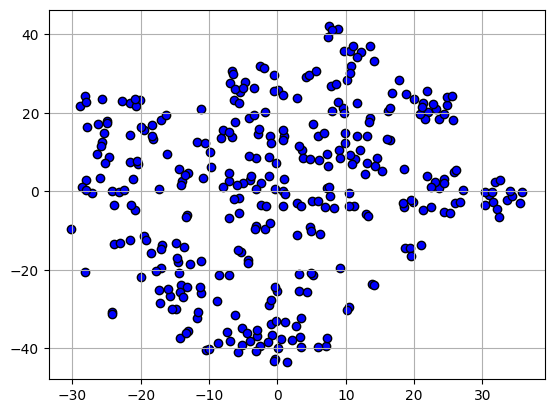

In [ ]:
import matplotlib.pyplot as plt

# Extracting the x and y values from the array
x_values = vis_dims[:, 0]
y_values = vis_dims[:, 1]
plt.scatter(x_values, y_values, c='blue', marker='o', edgecolor='black')
plt.grid(True)
plt.show()

## 來根據用戶查詢，找最相似的內容

https://github.com/openai/openai-cookbook/blob/main/examples/Semantic_text_search_using_embeddings.ipynb

* 又叫做 語意搜尋
* 也可以拿來做相似性內容推薦、產品推薦

稍後的 colab 我們會改用 ANN 算法，以及 Vector Database 幫我們處理。
這裡我們自幹，逐筆計算相似距離，找到最近的。

In [ ]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

### 每一筆都計算相似度，然後排序取分數最高的

In [ ]:
def search_similar(df, query, n=3):
    query_embedding = get_embeddings(query)
    df["similarity"] = df['embeddings'].apply(lambda x: cosine_similarity(x, query_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
    )
    return results


results = search_similar(df, "怎樣用 Python 做資料分析", n=5)
results

,title,description,category,embeddings,similarity
157,Python數據分析入門與實戰,本書從數據分析的基本概念和Python的基礎語法講起，然後逐步深入到Python數據分析的編...,數據分析,"[-0.02649242, 0.031430256, -0.01446803, -0.026...",0.506105
14,多變量分析：使用 SPSS 與 STATA,#以SPSS與STATA為主，兼採其他特定功能的統計軟體。\r\n#理論與應用並重，適合學位...,SPSS,"[-0.010746646, 0.029605767, -0.0048388536, -0....",0.496063
170,Python數據分析與數據可視化（微課版）,本書詳細講解Python擴展庫NumPy、Pandas、Matplotlib在數據分析與數據...,數據分析,"[-0.025375448, 0.029713772, -0.005231232, -0.0...",0.482710
135,Python 概率統計,本書以Python為工具，全面講解概率論與數理統計的主要內容和多元統計分析常用技術。全書包括...,統計學,"[0.01896234, -0.0042960155, 0.0053214296, -5.6...",0.469175
13,高效率 Python 自動化工作術｜快速解決 Excel、Word、PDF 資料處理,想指定年份與月份就完成月曆\r\n想找出使用了特定文字的PDF檔案\r\n想一口氣置換所有檔...,Excel,"[-0.004155928, 0.03401853, 0.022380142, 0.0076...",0.447890


## 分群應用

參考自 https://github.com/openai/openai-cookbook/blob/main/examples/Clustering.ipynb

K-Means 是最常見的分群算法，看你想要分成幾群，算法就會將距離比較近的 vectors 歸類成一群

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

matrix = np.vstack(df["embeddings"].values)
n_clusters = 4

kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42)
kmeans.fit(matrix)
df['Cluster'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

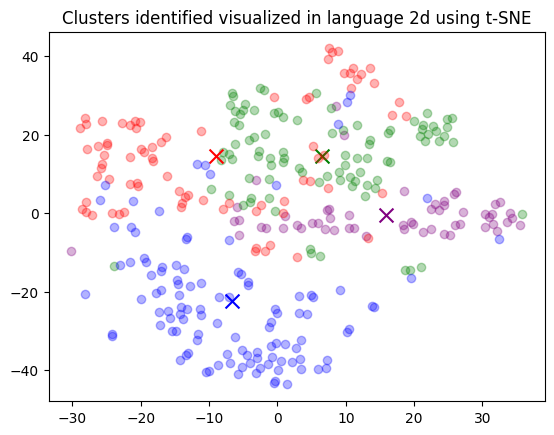

In [ ]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)

plt.title("Clusters identified visualized in language 2d using t-SNE")

## 透過 LLM 可幫每個群訂出一個主題(貼標)

In [ ]:
rev_per_cluster = 5 # 每群挑5本書來餵給 LLM

for i in range(n_clusters):
    print(f"Cluster {i} 主題:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .title
        .sample(rev_per_cluster, random_state=42)
        .values
    )

    messages = [
      {
        "role": "user",
        "content": f'以下書籍描述有什麼共通性，請回答一個分類主題: \n\ 內容: {reviews} 主題: '
      }
    ]

    response = get_completion(messages)
    print(response)

    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(" 書名: ", end=" ")
        print(sample_cluster_rows.title.values[j])
        # print(sample_cluster_rows.description.str[:70].values[j])

    print("-" * 100)

Cluster 0 主題: 資訊科技書籍
 書名:  PowerPoint 武功祕笈  2/e (舊名: PowerPoint 2010 精選教材 隨手翻)
 書名:  D3.js 資料視覺化實用攻略：完整掌握 Web 開發技術，繪製互動式圖表不求人（iThome鐵人賽系列書）
 書名:  中文版AutoCAD 2022機械設計從入門到精通（實戰案例版）（CAD/CAM/CAE微視頻講解大系）
 書名:  威力導演18 影片製作與剪接  2/e
 書名:  MySQL 數據庫應用案例課堂（第2版）
----------------------------------------------------------------------------------------------------
Cluster 1 主題: 大數據與人工智慧技術
 書名:  大數據技術導論
 書名:  ChatGPT 4 萬用手冊 2023 秋季號：超強外掛、Prompt、LineBot、OpenAI API、Midjourney、Stable Diffusion、Leonardo.ai
 書名:  大話機器學習——原理|算法|建模|代碼30講
 書名:  5G原理及其網絡優化
 書名:  1分鐘驚豔 ChatGPT 爆款文案寫作聖經：寫作教練 Vista 教你用 ChatGPT 寫出引人入勝的銷售文案
----------------------------------------------------------------------------------------------------
Cluster 2 主題: 理財及投資
 書名:  物理歷屆試題解析 (88-112年)
 書名:  一生金錢無虞平衡理財法
 書名:  持續買進：資料科學家的投資終極解答，存錢及致富的實證方法
 書名:  基礎微積分：在商學的應用  4/e
 書名:  【資安密碼系列】秘密不再是秘密：輕鬆認識密碼學-打造你的數位安全防線
----------------------------------------------------------------------------------------------------
Cluster 3 主題: 人工智慧和數據分析
 書名:  Th

## 補充: Google AI 的 Embedding APIs

https://ai.google.dev/docs/embeddings_guide

https://ai.google.dev/tutorials/rest_quickstart#embedding

In [4]:
gemini_api_key = userdata.get('gemini_api_key')

In [10]:
def get_google_embeddings(input, model="text-embedding-004"):
  payload = { "model": model, "content": { "parts": [ { "text": input }]} }
  headers = { "Content-Type": "application/json" }
  response = requests.post(f"https://generativelanguage.googleapis.com/v1beta/models/{model}:embedContent?key={gemini_api_key}", headers = headers, data = json.dumps(payload) )
  obj = json.loads(response.text)
  if response.status_code == 200 :
    return obj["embedding"]["values"]
  else :
    return obj

In [11]:
x = get_google_embeddings("test")

In [13]:
x

[0.02646778,
 0.01906776,
 -0.05332306,
 -0.0130286515,
 0.061046336,
 0.006660503,
 0.045478854,
 0.01929334,
 0.007008978,
 0.011352832,
 0.0014202943,
 0.018584058,
 0.02687894,
 -0.006143828,
 -0.02304342,
 -0.049634814,
 0.010657211,
 0.034044053,
 -0.07955659,
 -0.030889263,
 0.031800468,
 -0.042219035,
 -0.019197477,
 -0.016056145,
 -0.022037597,
 -0.03877505,
 -0.001626432,
 0.0365264,
 0.01747607,
 -0.035143483,
 0.009533407,
 0.010985599,
 0.036646456,
 0.0048380536,
 0.02374837,
 -0.0023861642,
 -0.004548893,
 0.027161457,
 0.0045787757,
 -0.055057064,
 0.015544719,
 0.06274155,
 -0.06934201,
 0.011607147,
 -0.042018943,
 -0.047859713,
 0.03269057,
 0.022275476,
 -0.021017695,
 0.03261926,
 0.061344974,
 0.08416165,
 -0.03389178,
 -0.014668169,
 0.015675923,
 -0.027049666,
 -0.008161635,
 -0.051441606,
 0.03126874,
 0.049743127,
 0.052860476,
 0.0040292274,
 -0.033263046,
 -0.023102505,
 0.024338217,
 -0.030350225,
 -0.009934357,
 -0.0051904297,
 -0.040548638,
 -0.014573513,

In [12]:
len(x)

768

In [14]:
  list_models = requests.get(f"https://generativelanguage.googleapis.com/v1beta/models?key={gemini_api_key}" )

In [15]:
pp( json.loads(list_models.content) )

{'models': [{'name': 'models/chat-bison-001',
             'version': '001',
             'displayName': 'PaLM 2 Chat (Legacy)',
             'description': 'A legacy text-only model optimized for chat '
                            'conversations',
             'inputTokenLimit': 4096,
             'outputTokenLimit': 1024,
             'supportedGenerationMethods': ['generateMessage',
                                            'countMessageTokens'],
             'temperature': 0.25,
             'topP': 0.95,
             'topK': 40},
            {'name': 'models/text-bison-001',
             'version': '001',
             'displayName': 'PaLM 2 (Legacy)',
             'description': 'A legacy model that understands text and '
                            'generates text as an output',
             'inputTokenLimit': 8196,
             'outputTokenLimit': 1024,
             'supportedGenerationMethods': ['generateText',
                                            'countTextTokens',
  